In [9]:
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd
from scipy.optimize import curve_fit
from scipy.stats import chisquare, iqr
from scipy import signal

# Get amplifier data from text file
def getAmpData(fileDir, fileName):
    freqs = []
    amps = []
    with open(fileDir + fileName, 'r') as f:
        for line in f:
            holder = line.split()
            freqs.append(float(holder[0])/1000.)
            amps.append(float(holder[1]))
    return np.asarray(freqs), np.asarray(amps)

# Definie a Gaussian function
def gaus(x,a,x0,sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))

# Label setup for plots
label_font = {'fontname':'Arial', 'size':'11', 'color':'black', 'weight':'normal',
          'verticalalignment':'bottom'} 
title_font = {'fontname':'sans-serif', 'size':'16', 'color':'black', 'weight':'bold'}
legend_font = {'family':'sans-serif', 'size':'10', 'style':'normal'} 

This Jupyter notebook will load in and analyze the data taken by the Spectran V6 spectrum analyzer. By this time, you should have successfully taken about 1 day of data that has been saved in a .CSV file. You will now analyze these data to look candidate dark photon signals and set a limit on the dark photon coupling strength, $\varepsilon$
over the frequency span you took data. We start by first loading this data into a dataframe.

In [76]:
#Set the directory and file name where your data are stored. DataDir is the relitive
#path. If you put the data in the same directory as this notebook leave it as "./"
dataDir = './'
fileName = '4Ghz-2MCs-1e6-1e5-dclosed-LR5.csv'

# Load the data in the .CSV into a tabular data structure called a pandas dataframe. This will allow 
# you to easily index and individual acquisitions and add them together. The first index gives the
# frequency. The second index is a time index. All values are given in 'dBm'. This can be converted to
# Watts via P_dBm = 10log10(P_W/1 mW)

dataDF = pd.read_csv(dataDir + fileName)

#Display the first few rows and columns
dataDF.head()

,time,3987242505.034009,3987246255.032529,3987250005.031050,3987253755.029570,3987257505.028090,3987261255.026610,3987265005.025131,3987268755.023651,3987272505.022171,...,4012719994.980788,4012723744.979308,4012727494.977829,4012731244.976349,4012734994.974869,4012738744.973390,4012742494.971910,4012746244.970430,4012749994.968950,4012753744.967471
0,1486.237033,-89.40,-89.45,-89.38,-89.40,-89.42,-89.46,-89.37,-89.42,-89.44,...,-89.63,-89.66,-89.69,-89.67,-89.66,-89.62,-89.62,-89.67,-89.66,-89.71
1,1512.903323,-89.43,-89.39,-89.41,-89.43,-89.39,-89.45,-89.40,-89.42,-89.36,...,-89.66,-89.62,-89.69,-89.65,-89.62,-89.65,-89.62,-89.67,-89.70,-89.65
2,1539.569616,-89.46,-89.39,-89.37,-89.41,-89.42,-89.43,-89.43,-89.40,-89.39,...,-89.64,-89.70,-89.62,-89.68,-89.66,-89.69,-89.65,-89.68,-89.61,-89.66
3,1566.235909,-89.42,-89.39,-89.47,-89.40,-89.44,-89.42,-89.42,-89.39,-89.43,...,-89.67,-89.65,-89.69,-89.64,-89.67,-89.64,-89.67,-89.65,-89.67,-89.61
4,1592.908224,-89.40,-89.41,-89.41,-89.42,-89.39,-89.43,-89.44,-89.37,-89.40,...,-89.64,-89.67,-89.69,-89.70,-89.62,-89.67,-89.71,-89.67,-89.67,-89.63


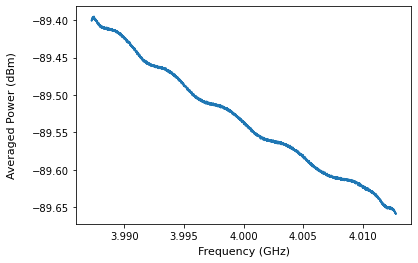

In [80]:
%matplotlib inline

# Averaging all the collected data together and store as numpy array 
amps = np.asarray([10**(np.asarray(dataDF[x])/10.).mean() for x in dataDF.columns[1:]])

# Extract bin frequencies of the data collected and store and numpy array
dataFreqs = np.asarray([float(x) for x in dataDF.columns[1:]])

#Plot
plt.plot(dataFreqs/10**9, 10*np.log10(amps))
plt.xlabel('Frequency (GHz)', labelpad = 15, **label_font)
plt.ylabel('Averaged Power (dBm)', labelpad = 15, **label_font)
plt.show()

Question: What is this spectrum showing us?

Question: How much variation (in %) do we see between the maximum 
          and minimum values?
          
Question: How would we go about determining if there is a dark photon signal
          on top of this baseline?

Question: In the empty cell below, replot this data in terms of Watts instead of dBm.

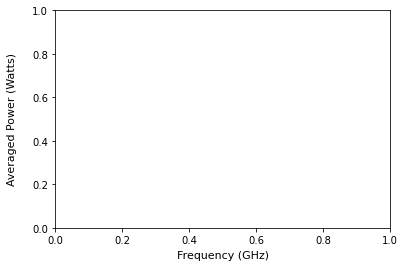

In [79]:
#Note to Ben; you can remove this and change the last question above. 
#I just thought it was weird to ask them to do something and then do it.
#I do like the interactive feeling it gives and this should only take 2 minutes

###############Your code here###############





############################################


plt.xlabel('Frequency (GHz)', labelpad = 15, **label_font)
plt.ylabel('Averaged Power (Watts)', labelpad = 15, **label_font)
plt.show()

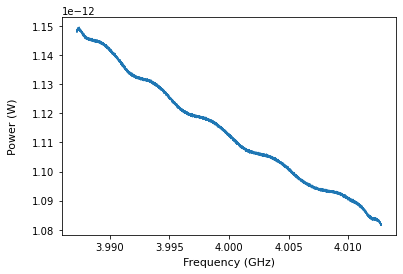

In [11]:
dataLin = (amps/1000.)
plt.plot(dataFreqs/10**9, dataLin)
plt.xlabel('Frequency (GHz)', labelpad = 15, **label_font)
plt.ylabel('Power (W)', labelpad = 15, **label_font)
plt.show()

This is the measured power at the Aaronia post amplification. It is also known as the **output-referred power**.
However, we would like to know the power measured by the antenna. This is known
as the **input-referred power**. The input-referred power is a combination of two parts:
The power from the antenna and the noise power due to the amplifiers. Therefore, to
turn the output-referred power to an input-referred power the following steps must be
performed:
1) Divide by the gain of the amplification chain. We have measured this for your and provide it in the 'ZX60Gain_Measured_BothAmps_5-30-22.npy' file.

2) Subtract the noise power of the amplifier. This is normally specified as a noise temperature $T$, given by $P = k_{B} \times T \times RBW$ where $P$ is the noise power, $k_{B}$ is Boltzmann's
constant and $RBW$ is the resolution bandwidth. Note $k_{B} \sim \frac{[Energy]}{[Temperture]}$, so $k_{B} \times T$ is a power per Hertz. This is known as power spectral density or **PSD**. Note: nose temperture data were taken from the manufacturer data sheet and provided in 'Minicircuits_ZX60-63GLN_NoiseFigure.txt'

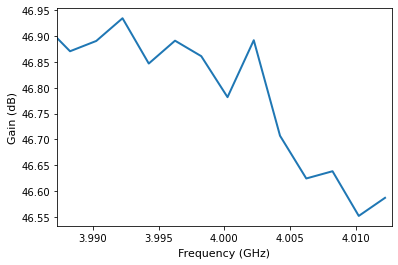

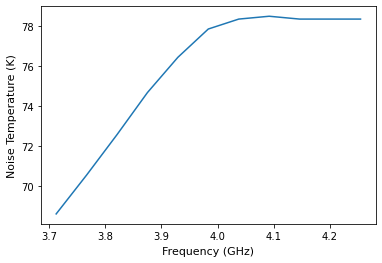

In [12]:
gainFile = 'ZX60Gain_Measured_BothAmps_5-30-22.npy'
nfFile = 'Minicircuits_ZX60-63GLN_NoiseFigure.txt'

# Load in gain data
measGains = np.load(dataDir + gainFile)
measGainFreqs = np.linspace(3.8, 4.2, 10000)
totalFitVals = 50

# Gain / noise temperature was taken over a larger frequency span than we care about. This narrows the displayed
# data to a region we care about.
startIndex = np.argmin(np.abs(measGainFreqs-dataFreqs[0]/10**9))
endIndex = np.argmin(np.abs(measGainFreqs-dataFreqs[-1]/10**9))
endIndex = endIndex + (totalFitVals - (endIndex - startIndex)%totalFitVals)
startIndex = startIndex - totalFitVals

# Smooth out the gain data. Compensates for some noise in the measurment set up. 
gainFitAmps = np.asarray([np.median(x) for x in measGains[startIndex:endIndex].reshape((-1, totalFitVals))])
gainFitFreqs = np.asarray([np.median(x) for x in measGainFreqs[startIndex:endIndex].reshape((-1, totalFitVals))])

# Get noise figure data and convert to a noise temperature
nfFreqs, nfVals = getAmpData(dataDir, nfFile)
nfVals = (10**(nfVals/10.)-1)*300.
nfStartIndex = np.argmin(np.abs(nfFreqs-dataFreqs[0]/10**9))
nfEndIndex = np.argmin(np.abs(nfFreqs-dataFreqs[-1]/10**9))

# Plot gain data
plt.plot(gainFitFreqs, gainFitAmps, linewidth = 2, label = 'Fit')
plt.xlim([dataFreqs[0]/10**9, dataFreqs[-1]/10**9])
plt.xlabel('Frequency (GHz)', labelpad = 15, **label_font)
plt.ylabel('Gain (dB)', **label_font)
#plt.legend(prop = legend_font)
plt.show()

# Plot noise temperature data
plt.plot(nfFreqs[nfStartIndex-5:nfEndIndex+5], nfVals[nfStartIndex-5:nfEndIndex+5])
plt.xlabel('Frequency (GHz)', labelpad = 15, **label_font)
plt.ylabel('Noise Temperature (K)', **label_font)
plt.show()



The above cell is taking in the gain and noise temperature files and plotting them.
Notice that the gain curve looks very bumpy, but the variation is only 0.4 dB. This is a
byproduct of the acquisition / fitting method.

Question: What is the noise power spectral density associated with a 75K noise temperature?

Question: If the resolution (RBW) is 3.75 kHz, what is the noise power we would measure due to the 75K amplifier? What if the resolution was 1 Hz? Do we measure the same noise power? Is this ok?

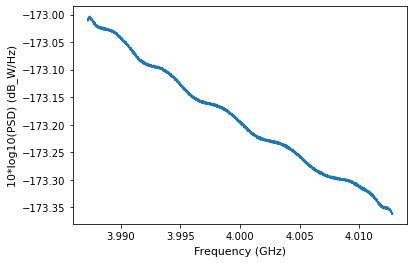

In [85]:
# Linearly interpolate gain values for all frequency bins in the acquired data
gainInterp = 10**(np.interp(dataFreqs, gainFitFreqs, gainFitAmps)/10.)

# Linearly interpolate noise temperature values for all frequency bins in the acquired data
# and conver to noise power
nfInterp = np.interp(dataFreqs, nfFreqs, nfVals)*(1.381*10**-23)*3750

# Subtract off the noise power and divide by the interpolated gain
dataCorrected = dataLin / gainInterp - nfInterp

# Plot power spectral density vs. frequency
plt.plot(dataFreqs/10**9, 10*np.log10(dataCorrected*1000/3750.))
plt.xlabel('Frequency (GHz)', labelpad = 15, **label_font)
plt.ylabel('10*log10(PSD) (dB_W/Hz)', **label_font)
plt.show()

The above shows the input referred PSD with the input noise temperature
of the amplifier subtracted out.

Question: What temperature does the median of the data represent (just guesstimate the median)?

Question: Does this make sense?

Question: What should the PSD be? Hint; Johnson-Nyquest noise

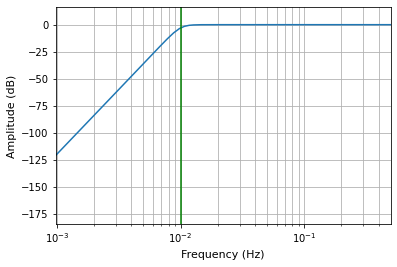

In [65]:
# Sampling rate such that the total amount of data is 1s
fs = len(dataFreqs)

# Cutoff in number of bins
fc = 100

# Normalize the frequency in term of Nyquist
fcNorm = 2./(fc)

# Create a 6th-order Butterworth filter - returns numerator (b) and denominator (a) polynomials of the IIR filter
b, a = signal.butter(6, fcNorm, 'highpass', analog = False)

# Compute the frequency response of a digital filter.
# w: The frequencies at which h was computed, in the same units as fs.
# h: The frequency response, as complex numbers.
w, h = signal.freqz(b, a, worN=512)
binNumberAxis = np.linspace(6000, 2, len(w))

# Plot the frequency response on a semilog plot
plt.semilogx(w / (2*np.pi), 20 * np.log10(abs(h)), label = 'High-Pass')
plt.margins(0, 0.1)
plt.grid(which='both', axis='both')
plt.axvline(1./fc, color='green') # cutoff frequency
plt.xlabel('Frequency (Hz)', labelpad = 15, **label_font)
plt.ylabel('Amplitude (dB)', **label_font)
plt.show()

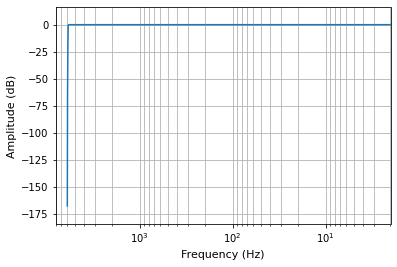

In [70]:
#Needs review. this looks weird in reverse log space. You can't see the filter shape
# Plot the frequency response on a semilog plot
#plt.semilogx(w / (2*np.pi), 20 * np.log10(abs(h)), label = 'High-Pass')
plt.semilogx(binNumberAxis, 20 * np.log10(abs(h)), label = 'High-Pass')
plt.gca().invert_xaxis()
plt.margins(0, 0.1)
plt.grid(which='both', axis='both')
#plt.axvline(1./fc, color='green') # cutoff frequency
plt.xlabel('Frequency (Hz)', labelpad = 15, **label_font)
plt.ylabel('Amplitude (dB)', **label_font)
plt.xlim(8000, 2)
plt.show()

We know that dark photon signals are very narrow (only a bin wide). We can use this fact to filter the power spectrum. Imagine that the entire power spectrum shows 1s of data. Then the effective sample rate is given by the total number of bins (in Hz). If we want to filter all features wider than n bins, then the cutoff frequency is given by totalBins/n. We show an example of such a filter above, where the cutoff f
Question: Why is this filter called a highpass filter?

Question: Why is this filter called a passive filter?

Question: How much does a 0.05 Hz signal get attenuated by?

[  0.88567329  -5.31403974  13.28509935 -17.7134658   13.28509935
  -5.31403974   0.88567329]


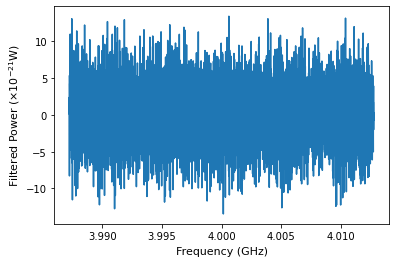

In [16]:

# Apply the Butterworth filter to the acquired data that has been corrected for the 
# noise power of the amplifiers and the gain of the amplifiers
filteredData = signal.filtfilt(b, a, dataCorrected)

# Plot the resulting data
plt.plot(dataFreqs/10**9, filteredData*10**21)
plt.xlabel('Frequency (GHz)', labelpad = 15, **label_font)
plt.ylabel(r'Filtered Power ($\times 10^{-21}$W)', **label_font)
plt.show()

Notice that applying the filter removes the baseline shaping of the unfiltered input referred power spectrum. However, it has also removed the DC offset. Thus, there are negative values even though the units are
still Watts. This is okay though because sensitivity to dark photons is related to the standard deviation of
this distribution not the mean. 

Question: Try setting the cutoff frequency on the filter to 10 bins. Then try setting it to 1,000. What happens? Why?

To see that this filtering has dramatically improved the simplicity in making significance claims, we histogram it, fit a Gaussian to the resulting distribution. By the Central Limit theorem, the data are (approximately) normally distributed. 

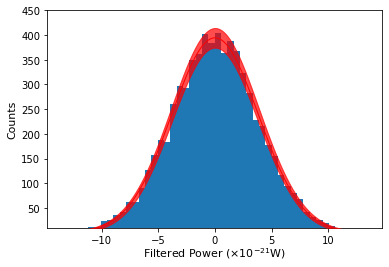

In [46]:
# Scale the filtered data to more sensible unit (zW)
scaledFilteredData = filteredData*10**21

# Apply the Freedman-Diaconis rule to determine bin widths / number of bins
binWidth = 2 * iqr(scaledFilteredData) / (len(scaledFilteredData)**(1./3.))
numBins = int((max(scaledFilteredData) - min(scaledFilteredData))/binWidth)

binSpace = np.linspace(min(scaledFilteredData), max(scaledFilteredData), numBins)

# Histogram the scaled and filtered power spectrum
n, bins, patches = plt.hist(scaledFilteredData, bins = binSpace, density = False)
plt.xlabel(r'Filtered Power ($\times 10^{-21}$W)', labelpad = 15, **label_font)
plt.ylabel('Counts', **label_font)

# Fit a Gaussian to the histogramm-ed data 
popt,pcov = curve_fit(gaus,(bins[1:] + bins[:-1])/2., n, p0=[390.0,0,np.std(scaledFilteredData)])

#fitAmps = gaus((bins[1:] + bins[:-1])/2., *popt)
#fitAmps = fitAmps*np.sum(n)/np.sum(fitAmps)


# Display the fitted Gaussian
fitFreqs = np.linspace(min(scaledFilteredData), max(scaledFilteredData), num = 200)
fitPlots = gaus(fitFreqs, *popt)
fitPlotsPlus = fitPlots + np.sqrt(fitPlots)
fitPlotsMinus = fitPlots - np.sqrt(fitPlots)
plt.plot(fitFreqs, fitPlots, 'r-', linewidth = 1)
plt.fill_between(fitFreqs, fitPlotsPlus, fitPlotsMinus, color = 'r', alpha = .7, zorder = 1000)
#plt.plot(fitFreqs, fitPlotsPlus, 'r-', linewidth = 3)
#plt.plot(fitFreqs, fitPlotsMinus, 'r-', linewidth = 3)
#plt.gca().set_yscale('lin')
plt.ylim(10, 450)
plt.show()

Question: How do we set a limit on $\varepsilon$?

We can determine a limit by setting a confidence interval. Namely, assuming that $n$ samples are drawn
from a normal distribution with the mean and standard deviation of the fitted curve, we set 
a confidence limit $C_{L}$ such that there is only a chance $p$ of seeing a variation of more
than $C_{L}$. $C_{L}$ can be defined in terms of the number of standard deviations, $\sigma$,
of the fitted Gaussian. Commonly, $p$ is set at 95%. For $n = 6804$ (the number of samples in
the spectrum), this limit is set at $4.33\sigma$. Note, we expect a dark photon to appear as a 
positive-going excursion on the baseline so do not consider negative-going signals as candidates.

With this in mind, we can now search through the data to see if there are any signals that are 4.3$\sigma$
or greater. If there are, we have found dark photon candidates! If there are not (or we can exclude candidates), we can set a 95% confidence limit over the span of the acquired data.

In [18]:
stdVal = popt[2]
totalCandidates = 0

# Scan through data frequencies and scaled filtered data for candidates
for val in zip (dataFreqs/10**9, scaledFilteredData):
    if val[1] > stdVal*4.33:
        totalCandidates += 1
        print(str(round(val[1]/stdVal, 3)) + u'\u03C3 CANDIDATE FOUND AT ' + str(round(val[0], 3)) + ' GHZ')

if(totalCandidates):
    print(str(totalCandidates) + ' CANDIDATES FOUND')
else:
    print('NO CANDIDATES FOUND')
stdVal *= 10**-21

NO CANDIDATES FOUND


Up to now, we have been looking at power. The question is, how do we convert from power to
a dark photon coupling constant, $\varepsilon$? Well, we know a couple of things:

1) We can relate the measured power, $P_{m}$ to an RMS voltage via
$$
V_{RMS} = \sqrt{\frac{P_{m}}{\lvert Z_{in} \rvert}}
$$
where $Z_{in}$ is the input impedance of the spectrum analyzer and is approximately 50$\Omega$.

2) The measured electric field, $E_{m}$ is related to the coupling constant $\varepsilon$ via 

$$
\begin{align}
E_{m} = 3,300\,V/m \cdot \varepsilon .
\end{align}
$$
This assumes that the local dark matter energy density is $0.3\,GeV/cm^{3}$.

However, we have measured a voltage, and $\varepsilon$ is related to the measured electrc field. How do we convert the two?

An antenna produces a voltage at its port depending on the incident field. The relationship between incident field and port voltage is called the antenna factor or $AF$ and has units of $m^{-1}$. It is defined as

$$
\begin{align}
E = V \times AF .
\end{align}
$$

The antenna factor is approximately given for some frequency, $\nu$, as

$$
\begin{align}
AF = \frac{9.73 \nu}{c}
\end{align}
$$

where $c$ is the speed of light. At $4\,\text{GHz}$, the $AF$ is approximately 130. We now have a relation between the measured power and the $AF$ given by

$$
\begin{align}
\varepsilon = {5.57\times 10^{-3} W^{-1/2}} \times \sqrt{P_{m}} = {5.57\times 10^{-3} W^{-1/2}} \times \sqrt{4.33\sigma_{P}}
\end{align}
$$

Code this into the line below to get a 95% confidence limit on $\varepsilon$.


In [19]:
epsVal = 5.57*10**-3*np.sqrt(4.3*stdVal)
print("{:.3e}".format(epsVal))

7.146e-13


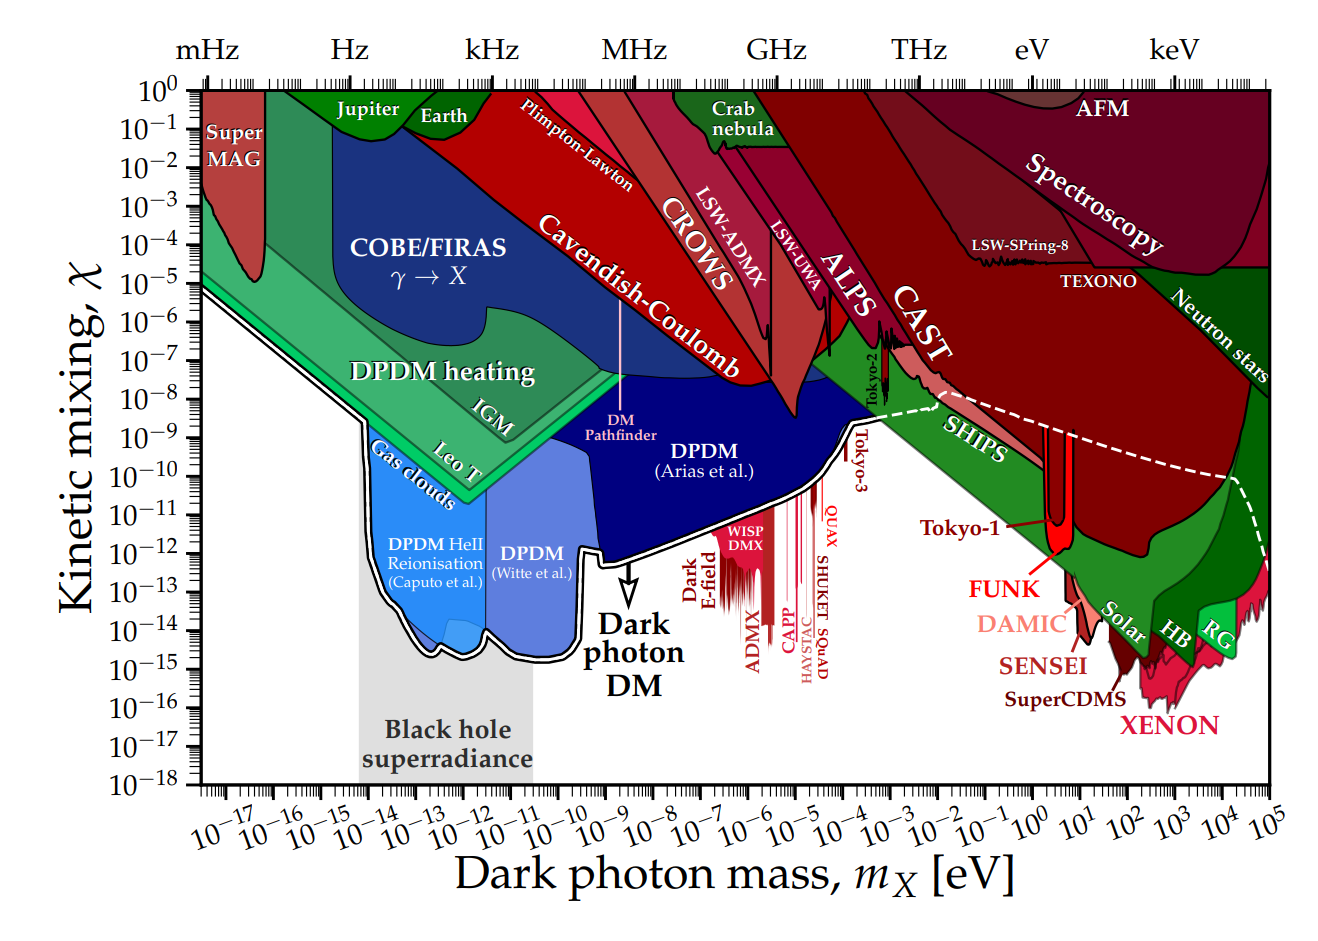